In [1]:

from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Read image
im = Image.open( 'hufflepuff.jpg' )


#Applying a filter to the image
im_sharp = im.filter( ImageFilter.SHARPEN )


In [59]:
image_shapes = {'hufflepuff':(4,3),
               'gryffindor':(6,5),
               'slytherin':(5,4),
               'ravenclaw':(4,4)}

In [62]:
for i in image_shapes.keys():
    print(image_shapes[i])

4
6
5
4


In [10]:
im_arr = np.asarray(im_sharp)

(4, 3)
(183, 193)
(6, 5)
(183, 193)
(5, 4)
(183, 193)
(4, 4)
(183, 193)


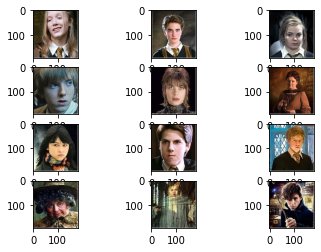

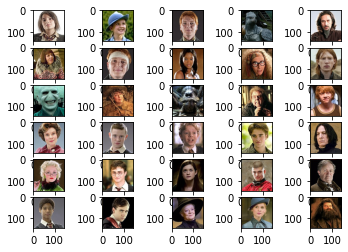

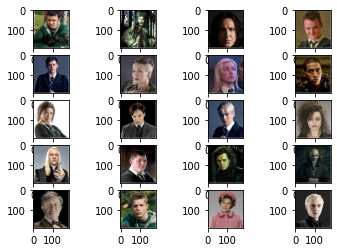

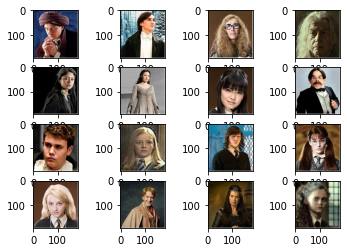

In [71]:
import os
for i in image_shapes.keys():
    print(image_shapes[i])
    im = Image.open( '%s.jpg' % i )
    
    os.mkdir(i)

    #Applying a filter to the image
    im_sharp = im.filter( ImageFilter.SHARPEN )

    height = im_sharp.height
    width = im_sharp.width

    h_n = image_shapes[i][1]
    w_n = image_shapes[i][0]

    h_y = np.floor(height/h_n)
    w_x = np.floor(width/w_n)

    x_b = 0
    y_b = 0

    fig, axs = plt.subplots(w_n,h_n)
    for x in range(1,w_n+1):
        y_b = 0
        for y in range(1,h_n+1):
            co_ords = (x_b,y_b,x*w_x,y*h_y)
            cr_im = im_sharp.crop(co_ords)
            axs[x-1,y-1].imshow(cr_im)
            cr_im = cr_im.resize((183,193),Image.ANTIALIAS)
            cr_im.save('%s/%s%i%i.jpg' % (i,i,x,y))
            
            y_b += h_y
        x_b += w_x

    print(cr_im.size)

In [2]:
import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import keras.applications as kapp
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 193
WIDTH = 183

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

Using plaidml.keras.backend backend.
INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"
/Users/craigledgerwood/MachineLearning/venv/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "harrypotter_train/"
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    batch_size=BATCH_SIZE,
                                                   target_size=(HEIGHT, WIDTH))

Found 78 images belonging to 4 classes.


In [6]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["griffindor", "hufflepuff", "slytherin", "ravenclaw"]
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))


In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 10
BATCH_SIZE = 8
num_train_images = 10000

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

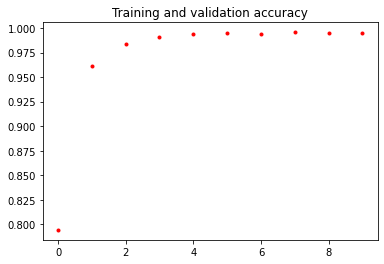

<Figure size 432x288 with 0 Axes>

In [12]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    loss = history.history['loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.title('Training and validation accuracy')

    # plt.figure()
    # plt.plot(epochs, loss, 'r.')
    # plt.plot(epochs, val_loss, 'r-')
    # plt.title('Training and validation loss')
    plt.show()

    plt.savefig('acc_vs_epochs.png')
    
plot_training(history)

In [11]:
history.history

{'loss': [0.6179038092428341,
  0.10136648917099228,
  0.04364207254202968,
  0.02687515478983146,
  0.020402999659819978,
  0.016503101448032118,
  0.018628178746528074,
  0.012775573245478488,
  0.017021189813477177,
  0.011476402446839614],
 'acc': [0.7943589756305401,
  0.9616410263134882,
  0.9842051285230197,
  0.990769231062669,
  0.9936410258488777,
  0.9944615386571639,
  0.9934358975826165,
  0.9956923077901204,
  0.9948717950307406,
  0.9951794873262063]}

In [13]:
im = Image.open( 'sadie.jpeg')

im_sharp = im.filter( ImageFilter.SHARPEN )
im_sharp = im_sharp.resize((183,193),Image.ANTIALIAS)

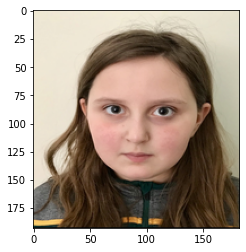

In [14]:
plt.imshow(im_sharp)

In [21]:
im_sharp.getdata()


In [24]:
def jpg_image_to_array(image_path):
    """
    Loads JPEG image into 3D Numpy array of shape 
    (width, height, channels)
    """
    with Image.open(image_path) as image: 
        image = image.filter( ImageFilter.SHARPEN )
        image = image.resize((183,193),Image.ANTIALIAS)
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape((image.size[1], image.size[0], 3))/255.                                  
    return im_arr

In [41]:
img = jpg_image_to_array('mummy.jpeg')

/Users/craigledgerwood/MachineLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


In [42]:
predict_class = finetune_model.predict(img.reshape(1,193,183,3))

In [43]:
class_list[np.argmax(predict_class)]

'griffindor'

In [44]:
predict_class

array([[9.9997377e-01, 1.0910001e-07, 1.2883350e-05, 1.3242722e-05]],
      dtype=float32)